<a href="https://colab.research.google.com/github/M4700F/BERT/blob/main/BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install datasets
!pip install pandas
!pip install optuna
!pip install torch
!pip install scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 17.0 MB/s eta 0:00:00
  

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Copyphishing.csv to Copyphishing.csv


In [ ]:
import pandas as pd

dataset = pd.read_csv("Copyphishing.csv")

cleaned_dataset = dataset[['Feature', 'Boolean']].dropna()
cleaned_dataset = cleaned_dataset.rename(columns={'Feature': 'text', 'Boolean': 'label'})

cleaned_dataset['label'] = cleaned_dataset['label'].astype(int)

print(cleaned_dataset.head())

                                                text  label
0  Dear eBay User ,\n\nAfter fraud complaints fro...      1
1  Dear valued customer, Our records indicate tha...      1
2  Dear Key Bank customer.  Please read this mess...      1
3  Dear Key Bank customer.  Please read this mess...      1
4  LEGAL NOTICE The following message is an email...      1


In [ ]:
from transformers import AutoTokenizer
from datasets import Dataset

# loading BERT Tokenizer...
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

dataset = Dataset.from_pandas(cleaned_dataset)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True)

# applying tokenization on each batch
tokenized_dataset = dataset.map(tokenize_function, batched=True)

print("Tokenized Data : \n")
print(tokenized_dataset[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/8194 [00:00<?, ? examples/s]

Tokenized Data : 

{'text': "Dear eBay User ,\\n\\nAfter fraud complaints from the eBay members, the eBay Inc. had\\ndeveloped a security program against the fraudulend attempts of accounts\\nthefts. For that we have to securise all the members informations by\\nupdating and checking the registrated informations. Please update  your\\ninformation by completing the form from the forwarded link so we can check\\nyour account validity and your identity\\nand login to eBay in order to update your informations.\\nThis process will take 5 days, period when you will not be able to\\nacces your eBay account. After this period you will receive instructions to\\nenter and securise your eBay account.Please click the link below and sign in into your account: http://signin.ebay.com/aw-cgi/eBayISAPI.dll?SignIn&ssPageName=h:h:sin:US -- As outlined in our User Agreement, eBay will periodically send you information about site changes and enhancements. Visit our Privacy Policy and User Agreement if you 

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch

# training -> 80%, validation -> 20%
train_dataset, val_dataset = tokenized_dataset.train_test_split(test_size=0.2).values()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=32,
    num_train_epochs=4,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    report_to="none"
)

# initializing ...
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
)

trainer.train()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-5-c3b1e88deaf2>:25: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,0.000300,0.004093
2,0.000200,0.005041
3,0.000200,0.003094
4,0.000900,0.002920


TrainOutput(global_step=3280, training_loss=0.01938596382473983, metrics={'train_runtime': 2990.2801, 'train_samples_per_second': 8.768, 'train_steps_per_second': 1.097, 'total_flos': 6898771871539200.0, 'train_loss': 0.01938596382473983, 'epoch': 4.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    predictions = predictions.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



trainer.compute_metrics=compute_metrics

evaluation_results = trainer.evaluate()
print("Evaluation Metrics:", evaluation_results)

Evaluation Metrics: {'eval_loss': 0.00292000244371593, 'eval_accuracy': 0.9993898718730934, 'eval_precision': 0.9988331388564761, 'eval_recall': 1.0, 'eval_f1': 0.9994162288382954, 'eval_runtime': 50.7346, 'eval_samples_per_second': 32.305, 'eval_steps_per_second': 1.025, 'epoch': 4.0}


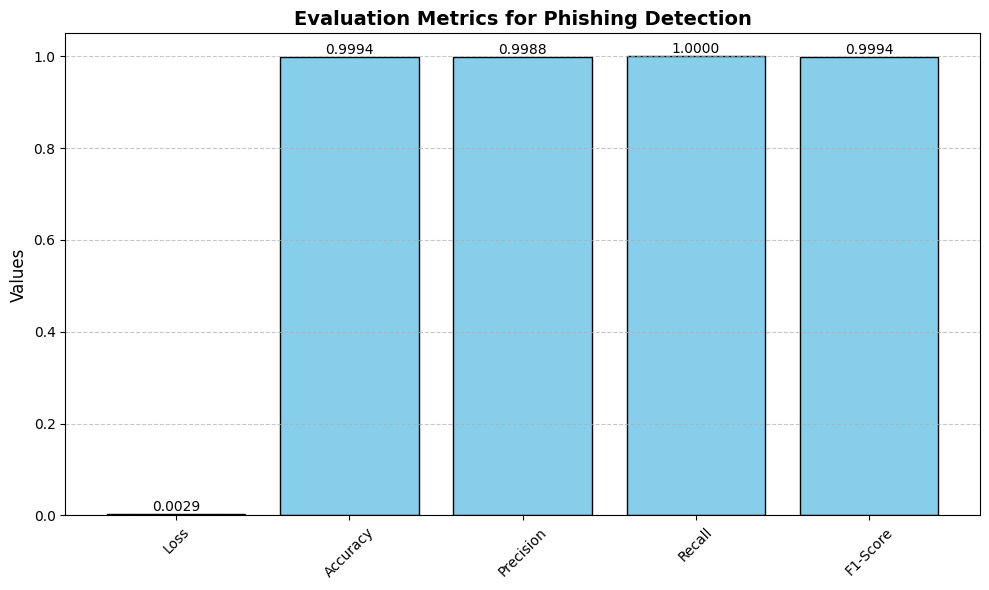

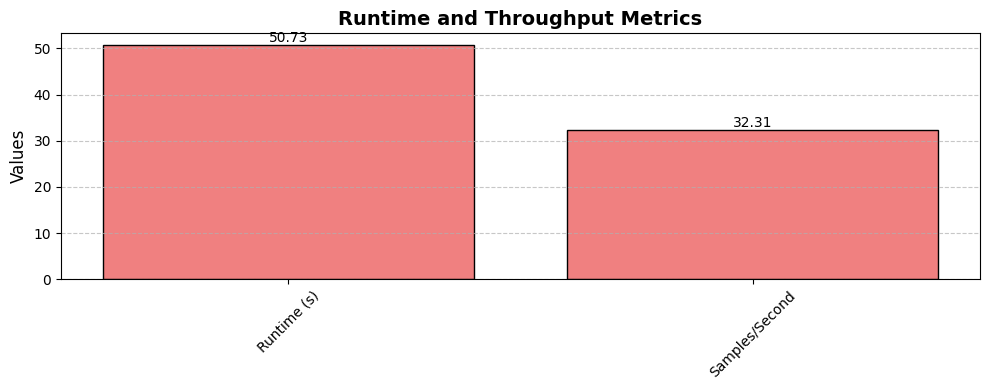

In [1]:
import matplotlib.pyplot as plt

# Metrics
metrics = {
    "Loss": 0.0029,
    "Accuracy": 0.9994,
    "Precision": 0.9988,
    "Recall": 1.0,
    "F1-Score": 0.9994,
    "Runtime (s)": 50.73,
    "Samples/Second": 32.31
}

# Separate keys and values
metric_names = list(metrics.keys())
metric_values = list(metrics.values())

# Bar chart for primary evaluation metrics (excluding runtime and samples per second)
plt.figure(figsize=(10, 6))
bars = plt.bar(metric_names[:5], metric_values[:5], color='skyblue', edgecolor='black')

# Adding value annotations on the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.4f}", ha='center', va='bottom', fontsize=10)

# Styling the bar chart
plt.title("Evaluation Metrics for Phishing Detection", fontsize=14, fontweight='bold')
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Create a second figure for runtime and throughput metrics
plt.figure(figsize=(10, 4))
runtime_bars = plt.bar(metric_names[5:], metric_values[5:], color='lightcoral', edgecolor='black')

# Adding value annotations on the bars
for bar in runtime_bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=10)

# Styling the runtime chart
plt.title("Runtime and Throughput Metrics", fontsize=14, fontweight='bold')
plt.ylabel("Values", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plots
plt.show()

In [ ]:
from torch.nn import CrossEntropyLoss

class_weights = torch.tensor([1.0, 2.0])
loss_fn = CrossEntropyLoss(weight=class_weights)
model.config.problem_type = "binary_classification"


In [ ]:
import optuna # optuna is a open-source hyperparameter optimization framework
from transformers import Trainer, TrainingArguments

def model_training(trial):

    learning_rate = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    num_epochs = trial.suggest_int("num_epochs", 3, 6)

    training_args = TrainingArguments(
        output_dir="./results",
        evaluation_strategy="epoch",
        learning_rate=learning_rate,
        per_device_train_batch_size=batch_size,
        num_train_epochs=num_epochs,
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        tokenizer=tokenizer,
    )

    trainer.train()
    evaluation_results = trainer.evaluate()
    return evaluation_results["eval_f1"]

# Running Optuna study ...
study = optuna.create_study(direction="maximize")
study.optimize(model_training, n_trials=10)

print("Best Hyperparameters:", study.best_params)


In [ ]:
model.save_pretrained("./phishing_model")
tokenizer.save_pretrained("./phishing_model")


('./phishing_model/tokenizer_config.json',
 './phishing_model/special_tokens_map.json',
 './phishing_model/vocab.txt',
 './phishing_model/added_tokens.json',
 './phishing_model/tokenizer.json')

In [ ]:
# for loading the model and tokenizer later
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model = AutoModelForSequenceClassification.from_pretrained("./phishing_model")
tokenizer = AutoTokenizer.from_pretrained("./phishing_model")


In [ ]:
def predict_email(email_text):

    inputs = tokenizer(email_text, return_tensors="pt", truncation=True, padding="max_length", max_length=512)

    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()  # 0: Non-phishing, 1: Phishing

    return "Phishing" if predicted_class == 1 else "Non-phishing"

email = "You have won $1,000,000. Click here to claim your prize!"
print(predict_email(email))


Phishing


In [ ]:
!zip -r phishing_model.zip ./phishing_model

  adding: phishing_model/ (stored 0%)
  adding: phishing_model/model.safetensors (deflated 7%)
  adding: phishing_model/vocab.txt (deflated 53%)
  adding: phishing_model/tokenizer_config.json (deflated 75%)
  adding: phishing_model/special_tokens_map.json (deflated 42%)
  adding: phishing_model/tokenizer.json (deflated 71%)
  adding: phishing_model/config.json (deflated 49%)


In [ ]:
from google.colab import files
files.download('phishing_model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install ucimlrepo

In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
phiusiil_phishing_url_website = fetch_ucirepo(id=967)

# data (as pandas dataframes)
X = phiusiil_phishing_url_website.data.features
y = phiusiil_phishing_url_website.data.targets

# metadata
print(phiusiil_phishing_url_website.metadata)

# variable information
print(phiusiil_phishing_url_website.variables)

                          name     role         type demographic description  \
0                     FILENAME    Other  Categorical        None        None   
1                          URL  Feature  Categorical        None        None   
2                    URLLength  Feature      Integer        None        None   
3                       Domain  Feature  Categorical        None        None   
4                 DomainLength  Feature      Integer        None        None   
5                   IsDomainIP  Feature      Integer        None        None   
6                          TLD  Feature  Categorical        None        None   
7           URLSimilarityIndex  Feature      Integer        None        None   
8         CharContinuationRate  Feature      Integer        None        None   
9            TLDLegitimateProb  Feature   Continuous        None        None   
10                 URLCharProb  Feature   Continuous        None        None   
11                   TLDLength  Feature 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/PhiUSIIL_Phishing_URL_Dataset.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install datasets

In [ ]:
import pandas as pd

dataset = pd.read_csv(file_path)

dataset.head()

,FILENAME,URL,URLLength,Domain,DomainLength,IsDomainIP,TLD,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,Title,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,521848.txt,https://www.southbankmosaics.com,31,www.southbankmosaics.com,24,0,com,100.0,1.000000,0.522907,0.061933,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,558,9381,1,à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µ...,0.000000,0.000000,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
1,31372.txt,https://www.uni-mainz.de,23,www.uni-mainz.de,16,0,de,100.0,0.666667,0.032650,0.050207,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,618,9381,1,johannes gutenberg-universitÃ¤t mainz,55.555556,55.555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
2,597387.txt,https://www.voicefmradio.co.uk,29,www.voicefmradio.co.uk,22,0,uk,100.0,0.866667,0.028555,0.064129,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,467,682,1,voice fm southampton,46.666667,46.666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1
3,554095.txt,https://www.sfnmjournal.com,26,www.sfnmjournal.com,19,0,com,100.0,1.000000,0.522907,0.057606,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,6356,26824,1,home page: seminars in fetal and neonatal medi...,0.000000,0.000000,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1
4,151578.txt,https://www.rewildingargentina.org,33,www.rewildingargentina.org,26,0,org,100.0,1.000000,0.079963,0.059441,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,6089,28404,1,fundaciÃ³n rewilding argentina,100.000000,100.000000,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1


In [ ]:
print(dataset.columns.tolist())

['FILENAME', 'URL', 'URLLength', 'Domain', 'DomainLength', 'IsDomainIP', 'TLD', 'URLSimilarityIndex', 'CharContinuationRate', 'TLDLegitimateProb', 'URLCharProb', 'TLDLength', 'NoOfSubDomain', 'HasObfuscation', 'NoOfObfuscatedChar', 'ObfuscationRatio', 'NoOfLettersInURL', 'LetterRatioInURL', 'NoOfDegitsInURL', 'DegitRatioInURL', 'NoOfEqualsInURL', 'NoOfQMarkInURL', 'NoOfAmpersandInURL', 'NoOfOtherSpecialCharsInURL', 'SpacialCharRatioInURL', 'IsHTTPS', 'LineOfCode', 'LargestLineLength', 'HasTitle', 'Title', 'DomainTitleMatchScore', 'URLTitleMatchScore', 'HasFavicon', 'Robots', 'IsResponsive', 'NoOfURLRedirect', 'NoOfSelfRedirect', 'HasDescription', 'NoOfPopup', 'NoOfiFrame', 'HasExternalFormSubmit', 'HasSocialNet', 'HasSubmitButton', 'HasHiddenFields', 'HasPasswordField', 'Bank', 'Pay', 'Crypto', 'HasCopyrightInfo', 'NoOfImage', 'NoOfCSS', 'NoOfJS', 'NoOfSelfRef', 'NoOfEmptyRef', 'NoOfExternalRef', 'label']


In [ ]:
text_columns = dataset.select_dtypes(include=['object']).columns.tolist()

print(text_columns)

['FILENAME', 'URL', 'Domain', 'TLD', 'Title']


In [ ]:
dataset["text"] = dataset["URL"] + " " + dataset["Domain"] + " " + dataset["TLD"] + dataset["Title"]
# pd.reset_option('display.max_colwidth')

print(dataset["text"].head())

0    https://www.southbankmosaics.com www.southbank...
1    https://www.uni-mainz.de www.uni-mainz.de dejo...
2    https://www.voicefmradio.co.uk www.voicefmradi...
3    https://www.sfnmjournal.com www.sfnmjournal.co...
4    https://www.rewildingargentina.org www.rewildi...
Name: text, dtype: object


In [ ]:
numerical_features = [
    "URLLength", "DomainLength", "IsDomainIP", "URLSimilarityIndex", "CharContinuationRate",
    "TLDLegitimateProb", "URLCharProb", "TLDLength", "NoOfSubDomain", "HasObfuscation",
    "NoOfObfuscatedChar", "ObfuscationRatio", "NoOfLettersInURL", "LetterRatioInURL",
    "NoOfDegitsInURL", "DegitRatioInURL", "NoOfEqualsInURL", "NoOfQMarkInURL",
    "NoOfAmpersandInURL", "NoOfOtherSpecialCharsInURL", "SpacialCharRatioInURL", "IsHTTPS",
    "LineOfCode", "LargestLineLength", "HasTitle", "DomainTitleMatchScore", "URLTitleMatchScore",
    "HasFavicon", "Robots", "IsResponsive", "NoOfURLRedirect", "NoOfSelfRedirect", "HasDescription",
    "NoOfPopup", "NoOfiFrame", "HasExternalFormSubmit", "HasSocialNet", "HasSubmitButton",
    "HasHiddenFields", "HasPasswordField", "Bank", "Pay", "Crypto", "HasCopyrightInfo", "NoOfImage",
    "NoOfCSS", "NoOfJS", "NoOfSelfRef", "NoOfEmptyRef", "NoOfExternalRef"
]

dataset = dataset[["text"] + numerical_features + ["label"]]

In [ ]:
dataset.head()

,text,URLLength,DomainLength,IsDomainIP,URLSimilarityIndex,CharContinuationRate,TLDLegitimateProb,URLCharProb,TLDLength,NoOfSubDomain,HasObfuscation,NoOfObfuscatedChar,ObfuscationRatio,NoOfLettersInURL,LetterRatioInURL,NoOfDegitsInURL,DegitRatioInURL,NoOfEqualsInURL,NoOfQMarkInURL,NoOfAmpersandInURL,NoOfOtherSpecialCharsInURL,SpacialCharRatioInURL,IsHTTPS,LineOfCode,LargestLineLength,HasTitle,DomainTitleMatchScore,URLTitleMatchScore,HasFavicon,Robots,IsResponsive,NoOfURLRedirect,NoOfSelfRedirect,HasDescription,NoOfPopup,NoOfiFrame,HasExternalFormSubmit,HasSocialNet,HasSubmitButton,HasHiddenFields,HasPasswordField,Bank,Pay,Crypto,HasCopyrightInfo,NoOfImage,NoOfCSS,NoOfJS,NoOfSelfRef,NoOfEmptyRef,NoOfExternalRef,label
0,https://www.southbankmosaics.com www.southbank...,31,24,0,100.0,1.000000,0.522907,0.061933,3,1,0,0,0.0,18,0.581,0,0.0,0,0,0,1,0.032,1,558,9381,1,0.000000,0.000000,0,1,1,0,0,0,0,1,0,0,1,1,0,1,0,0,1,34,20,28,119,0,124,1
1,https://www.uni-mainz.de www.uni-mainz.de dejo...,23,16,0,100.0,0.666667,0.032650,0.050207,2,1,0,0,0.0,9,0.391,0,0.0,0,0,0,2,0.087,1,618,9381,1,55.555556,55.555556,1,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,50,9,8,39,0,217,1
2,https://www.voicefmradio.co.uk www.voicefmradi...,29,22,0,100.0,0.866667,0.028555,0.064129,2,2,0,0,0.0,15,0.517,0,0.0,0,0,0,2,0.069,1,467,682,1,46.666667,46.666667,0,1,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,10,2,7,42,2,5,1
3,https://www.sfnmjournal.com www.sfnmjournal.co...,26,19,0,100.0,1.000000,0.522907,0.057606,3,1,0,0,0.0,13,0.500,0,0.0,0,0,0,1,0.038,1,6356,26824,1,0.000000,0.000000,0,1,1,0,0,0,1,12,0,1,1,1,0,0,1,1,1,3,27,15,22,1,31,1
4,https://www.rewildingargentina.org www.rewildi...,33,26,0,100.0,1.000000,0.079963,0.059441,3,1,0,0,0.0,20,0.606,0,0.0,0,0,0,1,0.030,1,6089,28404,1,100.000000,100.000000,0,1,1,1,1,1,0,2,0,1,1,1,0,1,1,0,1,244,15,34,72,1,85,1


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
numerical_data = scaler.fit_transform(dataset[numerical_features])

In [ ]:
from sklearn.model_selection import train_test_split

# Create a new dataframe with the numerical data and text data
numerical_df = pd.DataFrame(numerical_data, columns=numerical_features)
dataset = pd.concat([dataset[["text", "label"]], numerical_df], axis=1)

print(dataset.head())

                                                text  label  ...  NoOfEmptyRef  NoOfExternalRef
0  https://www.southbankmosaics.com www.southbank...      1  ...     -0.134778         0.464130
1  https://www.uni-mainz.de www.uni-mainz.de dejo...      1  ...     -0.134778         1.041672
2  https://www.voicefmradio.co.uk www.voicefmradi...      1  ...     -0.021406        -0.274876
3  https://www.sfnmjournal.com www.sfnmjournal.co...      1  ...     -0.078092        -0.113413
4  https://www.rewildingargentina.org www.rewildi...      1  ...     -0.078092         0.221935

[5 rows x 52 columns]


In [ ]:
data = dataset[["text", "label"]]

data["label"] = data["label"].astype(int)

print(data.head())

                                                text  label
0  https://www.southbankmosaics.com www.southbank...      1
1  https://www.uni-mainz.de www.uni-mainz.de dejo...      1
2  https://www.voicefmradio.co.uk www.voicefmradi...      1
3  https://www.sfnmjournal.com www.sfnmjournal.co...      1
4  https://www.rewildingargentina.org www.rewildi...      1


<ipython-input-30-0af874b123e3>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["label"] = data["label"].astype(int)


In [ ]:
from datasets import Dataset

data = Dataset.from_pandas(data)

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
  return tokenizer(examples['text'], padding="max_length", truncation=True)

tokenized_data = data.map(tokenize_function, batched=True)

print("Tokenized Data : \n")
print(tokenized_data[0])

Map:   0%|          | 0/235795 [00:00<?, ? examples/s]

Tokenized Data : 

{'text': 'https://www.southbankmosaics.com www.southbankmosaics.com comà¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸‚à¹ˆà¸²à¸§à¸\x81à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸\xadà¸±à¸žà¹€à¸”à¸—à¸ªà¸”à¹ƒà¸«à¸¡à¹ˆà¸—à¸¸à¸\x81à¸§à¸±à¸™ &#8211; à¸‚à¹ˆà¸²à¸§à¸ªà¸” à¸‚à¹ˆà¸²à¸§à¸\x81à¸µà¸¬à¸² à¸‚à¹ˆà¸²à¸§à¸šà¸±à¸™à¹€à¸—à¸´à¸‡ à¸‚à¹ˆà¸²à¸§à¸§à¸±à¸™à¸™à¸µà¹‰ à¸\xadà¸±à¸›à¹€à¸”à¸•à¸‚à¹ˆà¸²à¸§à¸ªà¸²à¸£à¸£à¸§à¸”à¹€à¸£à¹‡à¸§à¸—à¸±à¸™à¹ƒà¸ˆ à¸žà¸£à¹‰à¸\xadà¸¡à¸£à¸±à¸šà¸Šà¸¡à¸ªà¸²à¸£à¸°à¸™à¹ˆà¸²à¸£à¸¹à¹‰à¸•à¹ˆà¸²à¸‡à¹† à¹„à¸”à¹‰à¸Ÿà¸£à¸µà¸•à¸¥à¸\xadà¸” 24à¸Šà¸±à¹ˆà¸§à¹‚à¸¡à¸‡', 'label': 1, 'input_ids': [101, 16770, 1024, 1013, 1013, 7479, 1012, 2148, 9299, 15530, 4886, 6169, 1012, 4012, 7479, 1012, 2148, 9299, 15530, 4886, 6169, 1012, 4012, 100, 1522, 100, 1073, 100, 1524, 100, 1522, 100, 1073, 100, 1073, 100, 1530, 100, 1522, 100, 1073, 100, 100, 1522, 100, 1073, 100, 1517, 100, 1527, 100, 1524, 100, 1517, 100, 1524, 100, 1077, 100, 1067, 100, 1517, 100, 1073, 100, 100

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.model_selection import train_test_split
import torch

trained_data, val_data = tokenized_data.train_test_split(test_size=0.2).values()

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# training_args = TrainingArguments(
#     output_dir="./results",
#     evaluation_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=32,
#     num_train_epochs=4, # num_train_epochs=4 requires 17hrs
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     save_steps=500,
#     report_to="none"
# )

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Slightly larger batch size
    per_device_eval_batch_size=32,   # Slightly larger evaluation batch size
    num_train_epochs=1,  # Reduced epochs
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=500,
    save_total_limit=3,
    report_to="none",
    fp16=True,  # Enable mixed precision
    gradient_accumulation_steps=2,  # Accumulate gradients over 2 steps
    dataloader_num_workers=4,  # Parallelize data loading
    lr_scheduler_type="linear",  # Linear learning rate schedule
)


# initializing ...
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=trained_data,
    eval_dataset=val_data,
    tokenizer=tokenizer,
)

trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-38-d0e1b68bb02b>:44: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that 

Epoch,Training Loss,Validation Loss
1,0.012800,0.007452


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


TrainOutput(global_step=5895, training_loss=0.023977001722936816, metrics={'train_runtime': 4985.686, 'train_samples_per_second': 37.836, 'train_steps_per_second': 1.182, 'total_flos': 4.963221703888896e+16, 'train_loss': 0.023977001722936816, 'epoch': 1.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = torch.argmax(torch.tensor(logits), dim=-1)
    predictions = predictions.cpu().numpy()
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average="binary")
    accuracy = accuracy_score(labels, predictions)
    return {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}



trainer.compute_metrics=compute_metrics

evaluation_results = trainer.evaluate()
print("Evaluation Metrics:", evaluation_results)

Evaluation Metrics: {'eval_loss': 0.007452491205185652, 'eval_accuracy': 0.9984308403486079, 'eval_precision': 0.9978924015529673, 'eval_recall': 0.9993704869468617, 'eval_f1': 0.9986308973172988, 'eval_runtime': 326.7927, 'eval_samples_per_second': 144.309, 'eval_steps_per_second': 4.511, 'epoch': 1.0}
